# Creating Graph Representations for Molecules

This notebook demonstrates how to convert molecular data into graph representations suitable for Graph Neural Networks (GNNs). We will use libraries such as RDKit for molecule parsing, DGL-Life for graph construction, and NetworkX for additional graph processing and visualization.

**How to use this notebook:**

1. **Prerequisites:**  
   - Install the required packages:  (read docs to match cuda and dgl)
     pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html  
     pip install networkx 
     pip install dgllife 

2. **Data Loading:**  
   - The notebook assumes you have a DataFrame (loaded from a pickle file) containing a column with RDKit molecule objects and corresponding labels.

3. **Graph Creation:**  
   - It provides function `create_graphs_from_dataframe` to convert each molecule into a graph where atoms are nodes and bonds are edges, using `mol_to_bigraph` along with canonical featurizers.

4. **Visualization & Analysis:**  
   - Includes examples on how to visualize the generated graphs for verification and further exploration.

Follow the cells sequentially to process your dataset and generate graph representations for your molecules.

In [1]:
# Required installations:
# pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
# pip install networkx dgllife rdkit-pypi pandas

import json
import warnings
import pandas as pd
import torch
import matplotlib.pyplot as plt
import networkx as nx
import dgl
from dgllife.utils import mol_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

warnings.filterwarnings("ignore")

In [2]:
# Load the dataset (assumes "data.pkl" contains a DataFrame with a 'mol' column for RDKit Mol objects and a 'label' column)
df = pd.read_pickle("data.pkl")

In [3]:
df.head()

,mol,source,smiles,ecfp6,bit_info_map,label
3472,<rdkit.Chem.rdchem.Mol object at 0x7bb91eba9b70>,probes_drugs,CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3n...,0000000000000000000100000000000000000000010000...,"{19: [(6, 2)], 41: [(4, 1)], 80: [(6, 0), (8, ...",0
463,<rdkit.Chem.rdchem.Mol object at 0x7bb91eba9c10>,robin_b,CCOC(=O)/C(=N\O)C1=CSC2=NNC(C)(C)N12,0000000000000000000000000000000000000000000000...,"{69: [(8, 1)], 80: [(1, 0)], 91: [(6, 1)], 147...",1
2763,<rdkit.Chem.rdchem.Mol object at 0x7bb91eba9c60>,probes_drugs,C[C@H](N)[C@H](O)c1cccc(O)c1,0100000000000000000000000000000000000000000000...,"{1: [(1, 0), (3, 0)], 65: [(8, 2)], 220: [(3, ...",0
2384,<rdkit.Chem.rdchem.Mol object at 0x7bb91eba9cb0>,probes_drugs,CCN(CC)C(C)CN1c2ccccc2Sc2ccccc21,0100000000000000000000000000000000000000000000...,"{1: [(5, 0)], 80: [(1, 0), (3, 0), (7, 0)], 25...",0
2091,<rdkit.Chem.rdchem.Mol object at 0x7bb91eba9d00>,probes_drugs,Cc1[nH]n(-c2ccc3c(c2)CCCC3)c(=O)c1N=Nc1cccc(-c...,0000000000000000001000000000000000000100000000...,"{18: [(19, 1)], 37: [(32, 3)], 121: [(24, 1)],...",0


In [4]:
# Function to create DGL graphs from each molecule in the DataFrame
def create_graphs_from_dataframe(df):
    graphs, labels = [], []
    for _, row in df.iterrows():
        mol = row['mol']
        label = row['label']
        g = mol_to_bigraph(
            mol,
            node_featurizer=CanonicalAtomFeaturizer(),
            edge_featurizer=CanonicalBondFeaturizer(),
            explicit_hydrogens=False
        )
        g = dgl.add_self_loop(g)
        graphs.append(g)
        labels.append(label)
    return graphs, torch.tensor(labels).unsqueeze(1)

graphs, labels = create_graphs_from_dataframe(df)

In [5]:
# Save the graphs and some additional label information to disk
graph_info = df[['source', 'label']].to_dict('records')  # Adjust 'source' if necessary
dgl.save_graphs('molecule_graphs_orig.bin', graphs)
with open('graph_labels.json', 'w') as f:
    json.dump(graph_info, f)

# Later, we can reload the graphs and label info
loaded_graphs, _ = dgl.load_graphs('molecule_graphs_orig.bin')
with open('graph_labels.json', 'r') as f:
    loaded_graph_info = json.load(f)
reconstructed_df = pd.DataFrame(loaded_graph_info)

In [6]:
# For visualization, we'll select one molecule from the dataset.
# (Here we pick the 45th molecule; adjust the index as needed.)
row = df.iloc[44]
mol = row['mol']
AllChem.Compute2DCoords(mol)

# Create the graph for this molecule
graph = mol_to_bigraph(
    mol,
    node_featurizer=CanonicalAtomFeaturizer(atom_data_field='atomic_num'),
    edge_featurizer=CanonicalBondFeaturizer(),
    explicit_hydrogens=False
)
graph = dgl.add_self_loop(graph)

# The default atom featurizer returns one-hot encoded vectors.
# For molecules containing only C, N, O, and S, we assume:
#   0 -> C (6), 1 -> N (7), 2 -> O (8), 3 -> S (16)
onehot_to_atomic = {0: 6, 1: 7, 2: 8, 3: 16}

In [7]:
# Let's check that the decoded node features match the atoms in the RDKit molecule.
def check_atoms_match(g, mol):
    g_atoms = [
        onehot_to_atomic[int(torch.argmax(feat).item())] if feat.numel() > 1 else int(feat.item())
        for feat in g.ndata['atomic_num']
    ]
    mol_atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    if sorted(g_atoms) == sorted(mol_atoms):
        print("Atom check passed: Graph and molecule atoms match.")
    else:
        print("Atom check failed:")
        print("  Graph atoms:   ", sorted(g_atoms))
        print("  Molecule atoms:", sorted(mol_atoms))

check_atoms_match(graph, mol)

Atom check passed: Graph and molecule atoms match.


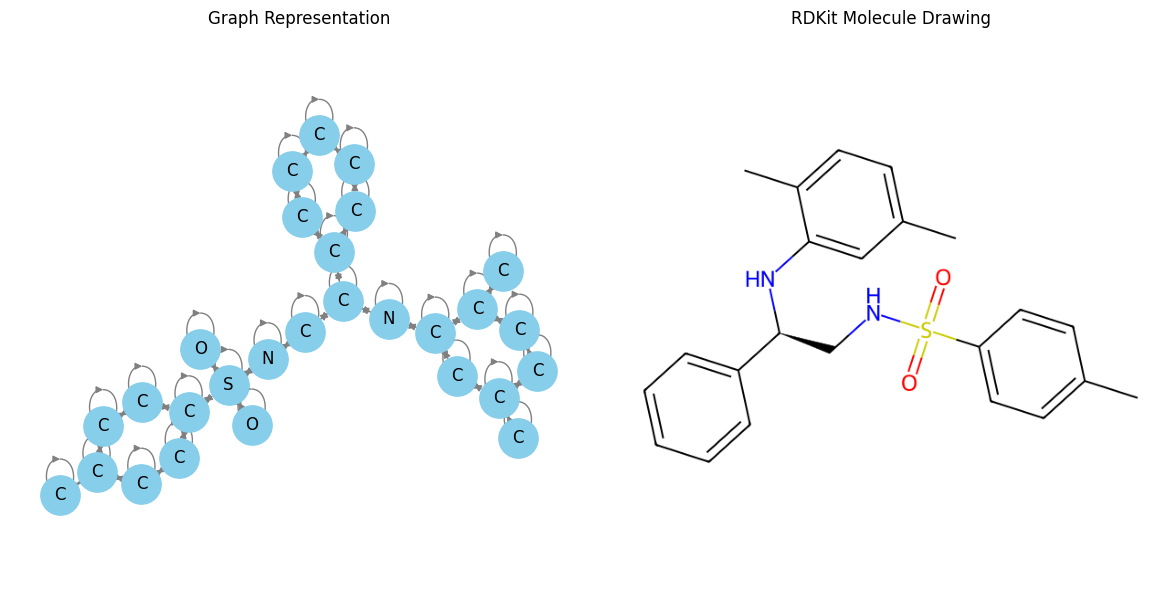

In [8]:
# Visualize the graph alongside the RDKit molecule drawing.
def visualize(g, mol):
    # Convert the DGL graph to a NetworkX graph and decode node features
    g_nx = dgl.to_networkx(g, node_attrs=['atomic_num'])
    pt = Chem.GetPeriodicTable()
    labels = {}
    for n, data in g_nx.nodes(data=True):
        feat = data['atomic_num']
        atomic_num = onehot_to_atomic[int(torch.argmax(feat).item())] if feat.numel() > 1 else int(feat.item())
        labels[n] = pt.GetElementSymbol(atomic_num)
    pos = nx.nx_agraph.graphviz_layout(g_nx, prog='neato')
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    nx.draw(g_nx, pos, labels=labels, node_color='skyblue', node_size=800, edge_color='gray')
    plt.title("Graph Representation")
    plt.axis('equal')
    
    plt.subplot(1, 2, 2)
    plt.imshow(Draw.MolToImage(mol, size=(600, 600)))
    plt.axis('off')
    plt.title("RDKit Molecule Drawing")
    
    plt.tight_layout()
    plt.show()

visualize(graph, mol)